# Test-3: Learning Mass of Dark Matter Halo 
###Image Shape - (150,150)
###Output -  Mass (single value)
###Metric - MSE

In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import MinMaxScaler,StandardScaler



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !tar -xzvf /content/drive/MyDrive/lens_data_alt.tgz

### Reading and preparing data

In [ ]:
path_to_data =                            #"/content/lens_data"
npy_data = glob.glob(path_to_data + "/*.npy")
images = []
y = []
for file in npy_data:
   a = np.load(file,allow_pickle=True)
   images.append(a[0])
   y.append(a[1]) 

images = np.array(images).astype('float')
y = np.array(y).astype('float').reshape(-1, 1)

images = images.reshape(-1,150,150,1)

### Normalising masses 
### Input values scaled between 0 and 1. Standardizing inputs had no significant improvement 

In [ ]:
norm = MinMaxScaler()
norm.fit(y)
y = norm.transform(y)

# scaler = StandardScaler()
# scaler.fit(images)
# X = scaler.transform(images).reshape(-1,150,150,1)
X = images/255

In [ ]:
print('y \nmean / std dev / max / min : %0.4f / %0.4f / %0.4f / %0.4f\n'%(y.mean(), y.std(), y.max(), y.min() ))

y 
mean / std dev / max / min : 0.3710 / 0.1396 / 1.0000 / 0.0000



Deleting temporary variables

In [ ]:
del images
gc.collect()

419

## Importing important Keras functions

In [ ]:
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization,RandomFlip ,RandomRotation,RandomCrop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.random import set_seed
set_seed(42)





###Setting parameters for the model

In [ ]:
lr_init     = 1.e-4     # Initial learning rate  
batch_size  = 64       # Training batch size
epochs      = 25       # Number of epochs
doGPU       = True    # Use GPU
img_rows = 150
img_cols = 150

In [ ]:
if doGPU:
    import tensorflow.compat.v1 as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

In [ ]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


###Augmentation layer to prevent overfitting

In [ ]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),    # Random flipping of the image
  RandomRotation((0,1)),                    # Rotation from 0 to 360 degrees
  RandomCrop(150,150)                       # random cropping 
])

#Main Model

ResNet50 

Pre-trained weight

All layers trainable

Pre-trained weights helps in converging early, so does the making all the layers trainable (determined by experimentation).

To feed the image to ResNet, image had to be made of 3 channels.
There were 2 options.
1. Add a Convolution layer
2. Make 3 channel image with same values in all the channels.

    1st option gave better results.

Loss for Regression - Root Mean Sqaured Error

Extra metric- Mean Absolute Percentage error (gives extremely large values for close to 0, used here just to observe the general trend.)


In [ ]:
ResNet50_model = ResNet50(weights= 'imagenet', include_top=False, input_shape=(150,150,3), classes=3)
for layers in ResNet50_model.layers:
    layers.trainable= True
opt = Adam(learning_rate=lr_init)


model = tf.keras.Sequential([ 
                             data_augmentation,
                             Conv2D(3,(3,3),padding='same'),   
                             ResNet50_model,
                             Flatten(),
                             Dense(256,activation='relu'),
                             Dropout(0.5),
                             Dense(1,activation='sigmoid')      # After comparison, chose sigmoid instead of linear for normalised values.
                            ])

model.compile(loss = rmse, optimizer= opt, metrics=['mean_squared_error','mape'])




94781440/94765736 [==============================] - 1s 0us/step


Fitting the model.

Used 2 callbacks to reduce learning rate and for early stopping, based on changes in validation loss.

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-8)
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
history=model.fit(X, y,\
        batch_size=batch_size,\
        epochs=epochs,\
        # validation_data=(x_val, y_val),\
        callbacks=[reduce_lr, earlyStopping ],\
        verbose=1, shuffle=True,
        validation_split=0.1)

Epoch 1/25
282/282 [==============================] - 237s 759ms/step - loss: 0.1816 - mean_squared_error: 0.0394 - mape: 20708.4082 - val_loss: 0.1439 - val_mean_squared_error: 0.0209 - val_mape: 43.9149 - lr: 1.0000e-04
Epoch 2/25
282/282 [==============================] - 212s 752ms/step - loss: 0.1297 - mean_squared_error: 0.0170 - mape: 26273.4785 - val_loss: 0.1537 - val_mean_squared_error: 0.0238 - val_mape: 36.7276 - lr: 1.0000e-04
Epoch 3/25
282/282 [==============================] - 215s 762ms/step - loss: 0.1162 - mean_squared_error: 0.0137 - mape: 13461.6426 - val_loss: 0.1375 - val_mean_squared_error: 0.0190 - val_mape: 39.4784 - lr: 1.0000e-04
Epoch 4/25
282/282 [==============================] - 210s 746ms/step - loss: 0.1087 - mean_squared_error: 0.0119 - mape: 11565.6729 - val_loss: 0.2335 - val_mean_squared_error: 0.0547 - val_mape: 51.8713 - lr: 1.0000e-04
Epoch 5/25
282/282 [==============================] - 209s 742ms/step - loss: 0.1064 - mean_squared_error: 0.011

###Validation MSE over training

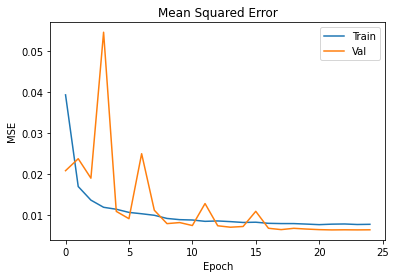

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
model.save_weights('model.h5')
from google.colab import files
files.download('model.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>